In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [3]:
args = load_param('saved_models/kgc/AbbeyGrange075/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2022-12-31 04:16:18 - INFO - 3505047770.py - 13 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/AbbeyGrange075/03/log.log', param_file='saved_models/kgc/AbbeyGrange075/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/AbbeyGrange075/03/checkpoint/', model_path='saved_models/kgc/AbbeyGrange075/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=True, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge090=False, use_for_challenge075=True, use_title='AbbeyGrange', do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, sep_token_s=3, bos_t

In [ ]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
print(len(data_helper.processed_train_triple), len(triple))

In [5]:
from run_for_KGC import get_all_tokens
to_token = "{}".format
PAD_E = to_token("pad_e")
CLS_E = to_token('cls_e')
MASK_E: Final[str] = to_token('mask_e')
SEP_E: Final[str] = to_token('sep_e')
BOS_E: Final[str] = to_token('bos_e')
PAD_R: Final[str] = to_token('pad_r')
CLS_R: Final[str] = to_token('cls_r')
MASK_R: Final[str] = to_token('mask_r')
SEP_R: Final[str] = to_token('sep_r')
BOS_R: Final[str] = to_token('bos_r')

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)

In [6]:
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [7]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [8]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [9]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [10]:
story_entities = triple_df['head'].tolist()
print(story_entities)

['bos_e', 'AbbeyGrange:001', 'AbbeyGrange:001', 'AbbeyGrange:001', 'AbbeyGrange:001', 'AbbeyGrange:001', 'AbbeyGrange:001', 'AbbeyGrange:001', 'AbbeyGrange:001', 'bos_e', 'AbbeyGrange:002', 'AbbeyGrange:002', 'AbbeyGrange:002', 'AbbeyGrange:002', 'AbbeyGrange:002', 'AbbeyGrange:002', 'bos_e', 'AbbeyGrange:003', 'AbbeyGrange:003', 'AbbeyGrange:003', 'AbbeyGrange:003', 'AbbeyGrange:003', 'AbbeyGrange:003', 'AbbeyGrange:003', 'AbbeyGrange:003', 'AbbeyGrange:003', 'bos_e', 'AbbeyGrange:004', 'AbbeyGrange:004', 'AbbeyGrange:004', 'AbbeyGrange:004', 'bos_e', 'AbbeyGrange:005', 'AbbeyGrange:005', 'AbbeyGrange:005', 'AbbeyGrange:005', 'AbbeyGrange:005', 'bos_e', 'AbbeyGrange:006', 'AbbeyGrange:006', 'AbbeyGrange:006', 'bos_e', 'AbbeyGrange:007', 'AbbeyGrange:007', 'AbbeyGrange:007', 'AbbeyGrange:007', 'AbbeyGrange:007', 'bos_e', 'AbbeyGrange:008', 'AbbeyGrange:008', 'AbbeyGrange:008', 'AbbeyGrange:008', 'AbbeyGrange:008', 'bos_e', 'AbbeyGrange:009', 'AbbeyGrange:009', 'AbbeyGrange:009', 'bos_e

In [11]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [12]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

### 僧坊荘園
Who killed Lord Blackenstall? (criminal & explanation)
被害者: Sir_Eustace_Brackenstall
犯人: 
犯行動機: 

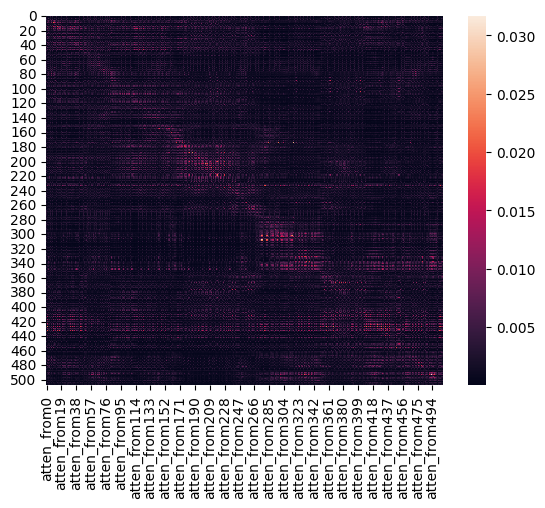

,predicate,whom,subject,why,what,where
0,word.predicate:exist,AbbeyGrange:Criminal,AbbeyGrange:Jack_Croker,AbbeyGrange:dust,ACaseOfIdentity:Sutherland,AllTitle:Holmes
1,word.predicate:kill,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:Lady_Brackenstall,ACaseOfIdentity:Hosmer,AllTitle:Holmes,AbbeyGrange:dining_room
2,word.predicate:say,AllTitle:Holmes,AbbeyGrange:Criminal,CrookedMan:Teddy,DateTime:1898-08-13T03:02:00,AbbeyGrange:Theresa
3,word.predicate:enter,ACaseOfIdentity:Sutherland,AllTitle:Holmes,ACaseOfIdentity:Sutherland,AbbeyGrange:Lady_Brackenstall,ACaseOfIdentity:Sutherland
4,word.predicate:have,AbbeyGrange:Sir_Eustace_Brackenstall,ACaseOfIdentity:Sutherland,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:cord_of_bell,AbbeyGrange:Lady_Brackenstall
5,word.predicate:go,AbbeyGrange:Jack_Croker,AbbeyGrange:Theresa,CrookedMan:Morrison,AbbeyGrange:Criminal,DevilsFoot:living_room
6,word.predicate:sit,AbbeyGrange:Theresa,AbbeyGrange:Sir_Eustace_Brackenstall,AbbeyGrange:041,CrookedMan:Murphy,SilverBlaze:Silver_Blaze
7,word.predicate:find,CrookedMan:Murphy,CrookedMan:Barclay,AbbeyGrange:Criminal,AbbeyGrange:Sir_Eustace_Brackenstall,AbbeyGrange:Abbey_Grange
8,ACaseOfIdentity:Sutherland,CrookedMan:Barclay,DateTime:1898-08-13T03:02:00,word.predicate:see,AbbeyGrange:cork_of_bottle,AbbeyGrange:Stanley_Hopkins
9,word.predicate:meet,SilverBlaze:Silver_Blaze,CrookedMan:Rasheen,DancingMen:Horse_boy,ACaseOfIdentity:Hosmer,DancingMen:Horse_boy


488

['AbbeyGrange:307', 'kgc:when', 'AbbeyGrange:end_of_case']

,head,relation,tail,atten_from488
424,AbbeyGrange:296,kgc:subject,AbbeyGrange:Holes_of_pond,0.011472
397,AbbeyGrange:291,kgc:what,AbbeyGrange:290,0.009519
348,AbbeyGrange:283,kgc:hasProperty,word.predicate:faithful,0.008872
346,AbbeyGrange:283,kgc:subject,AbbeyGrange:Jack_Croker,0.008257
343,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.008145
347,AbbeyGrange:283,kgc:hasProperty,word.predicate:Friendly,0.008079
309,AbbeyGrange:274,kgc:time,DateTime:1897-02-01T12:00:00,0.007909
305,AbbeyGrange:274,kgc:subject,AbbeyGrange:Jack_Croker,0.007587
407,AbbeyGrange:292a,kgc:what,AbbeyGrange:bottom_of_pond_of_garden,0.007096
473,AbbeyGrange:304,kgc:hasProperty,word.predicate:unofficial,0.006978


----------


489

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from489
294,AbbeyGrange:272,kgc:hasPredicate,word.predicate:exist,0.005741
287,AbbeyGrange:271,kgc:hasPredicate,word.predicate:exist,0.005521
96,bos_e,bos_r,bos_e,0.005259
90,bos_e,bos_r,bos_e,0.005160
107,bos_e,bos_r,bos_e,0.005043
101,bos_e,bos_r,bos_e,0.005007
5,bos_e,bos_r,bos_e,0.004832
8,bos_e,bos_r,bos_e,0.004790
47,bos_e,bos_r,bos_e,0.004785
184,bos_e,bos_r,bos_e,0.004784


----------


490

['AbbeyGrange:308', 'kgc:subject', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from490
493,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.016459
335,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.011512
233,AbbeyGrange:260,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.011356
427,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010651
490,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.010488
343,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.010390
432,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.010165
480,AbbeyGrange:306,kgc:subject,AbbeyGrange:Stanley_Hopkins,0.009503
413,AbbeyGrange:293,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.009427
346,AbbeyGrange:283,kgc:subject,AbbeyGrange:Jack_Croker,0.009307


----------


491

['AbbeyGrange:308', 'kgc:hasProperty', 'word.predicate:manly']

,head,relation,tail,atten_from491
339,AbbeyGrange:281,kgc:subject,AbbeyGrange:Personality_of_Jack_Croker,0.011849
343,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.011600
305,AbbeyGrange:274,kgc:subject,AbbeyGrange:Jack_Croker,0.010945
497,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.010490
493,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.010203
330,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.010151
490,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.009291
299,AbbeyGrange:273,kgc:subject,AbbeyGrange:Jack_Croker,0.008748
346,AbbeyGrange:283,kgc:subject,AbbeyGrange:Jack_Croker,0.008490
335,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.008461


----------


492

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from492
294,AbbeyGrange:272,kgc:hasPredicate,word.predicate:exist,0.005790
287,AbbeyGrange:271,kgc:hasPredicate,word.predicate:exist,0.005638
96,bos_e,bos_r,bos_e,0.005224
90,bos_e,bos_r,bos_e,0.005127
107,bos_e,bos_r,bos_e,0.005020
101,bos_e,bos_r,bos_e,0.004984
47,bos_e,bos_r,bos_e,0.004828
5,bos_e,bos_r,bos_e,0.004818
184,bos_e,bos_r,bos_e,0.004780
8,bos_e,bos_r,bos_e,0.004772


----------


493

['AbbeyGrange:309', 'kgc:subject', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from493
493,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.030657
330,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.013808
344,AbbeyGrange:282,kgc:hasProperty,word.predicate:inpatient,0.013551
335,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.013333
490,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.013247
347,AbbeyGrange:283,kgc:hasProperty,word.predicate:Friendly,0.012437
497,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.011693
343,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.011111
491,AbbeyGrange:308,kgc:hasProperty,word.predicate:manly,0.010157
348,AbbeyGrange:283,kgc:hasProperty,word.predicate:faithful,0.010091


----------


494

['AbbeyGrange:309', 'kgc:hasPredicate', 'word.predicate:come']

,head,relation,tail,atten_from494
337,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.015892
330,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.014712
493,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.012285
348,AbbeyGrange:283,kgc:hasProperty,word.predicate:faithful,0.011750
332,AbbeyGrange:279,kgc:what,AbbeyGrange:Comparable_Officer,0.011114
343,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.010519
305,AbbeyGrange:274,kgc:subject,AbbeyGrange:Jack_Croker,0.010205
490,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.010205
320,AbbeyGrange:276,kgc:what,AbbeyGrange:The_Bays_Rock,0.010041
339,AbbeyGrange:281,kgc:subject,AbbeyGrange:Personality_of_Jack_Croker,0.009430


----------


495

['AbbeyGrange:309', 'kgc:where', 'AbbeyGrange:room_of_Holmes']

,head,relation,tail,atten_from495
337,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.015025
333,AbbeyGrange:279,kgc:where,AbbeyGrange:any_ship,0.013951
493,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.013841
495,AbbeyGrange:309,kgc:where,AbbeyGrange:room_of_Holmes,0.011632
335,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.011464
343,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.011233
330,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.010818
332,AbbeyGrange:279,kgc:what,AbbeyGrange:Comparable_Officer,0.010574
305,AbbeyGrange:274,kgc:subject,AbbeyGrange:Jack_Croker,0.009363
322,AbbeyGrange:277,kgc:subject,AbbeyGrange:Jack_Croker,0.009007


----------


496

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from496
287,AbbeyGrange:271,kgc:hasPredicate,word.predicate:exist,0.006162
294,AbbeyGrange:272,kgc:hasPredicate,word.predicate:exist,0.006100
96,bos_e,bos_r,bos_e,0.005194
90,bos_e,bos_r,bos_e,0.005122
107,bos_e,bos_r,bos_e,0.004970
101,bos_e,bos_r,bos_e,0.004935
47,bos_e,bos_r,bos_e,0.004806
5,bos_e,bos_r,bos_e,0.004782
184,bos_e,bos_r,bos_e,0.004779
8,bos_e,bos_r,bos_e,0.004717


----------


497

['AbbeyGrange:310', 'kgc:subject', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from497
493,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.019658
497,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.013338
335,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.012278
343,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.011178
490,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.011054
491,AbbeyGrange:308,kgc:hasProperty,word.predicate:manly,0.010977
233,AbbeyGrange:260,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.010714
432,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.010693
344,AbbeyGrange:282,kgc:hasProperty,word.predicate:inpatient,0.010591
305,AbbeyGrange:274,kgc:subject,AbbeyGrange:Jack_Croker,0.009978


----------


498

['AbbeyGrange:310', 'kgc:hasProperty', 'word.predicate:nimble-footed']

,head,relation,tail,atten_from498
343,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.011198
305,AbbeyGrange:274,kgc:subject,AbbeyGrange:Jack_Croker,0.011131
339,AbbeyGrange:281,kgc:subject,AbbeyGrange:Personality_of_Jack_Croker,0.009296
497,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.009038
299,AbbeyGrange:273,kgc:subject,AbbeyGrange:Jack_Croker,0.008405
490,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.008346
493,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.007860
335,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.007687
330,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.006843
346,AbbeyGrange:283,kgc:subject,AbbeyGrange:Jack_Croker,0.006601


----------


499

['AbbeyGrange:310', 'kgc:when', 'AbbeyGrange:309']

,head,relation,tail,atten_from499
305,AbbeyGrange:274,kgc:subject,AbbeyGrange:Jack_Croker,0.012103
343,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.011110
311,AbbeyGrange:275,kgc:subject,AbbeyGrange:The_Bays_Rock,0.008738
309,AbbeyGrange:274,kgc:time,DateTime:1897-02-01T12:00:00,0.008431
339,AbbeyGrange:281,kgc:subject,AbbeyGrange:Personality_of_Jack_Croker,0.008252
348,AbbeyGrange:283,kgc:hasProperty,word.predicate:faithful,0.008025
347,AbbeyGrange:283,kgc:hasProperty,word.predicate:Friendly,0.007321
346,AbbeyGrange:283,kgc:subject,AbbeyGrange:Jack_Croker,0.007263
286,AbbeyGrange:271,kgc:subject,AbbeyGrange:Rock-of-Gibraltar,0.007065
303,AbbeyGrange:273,kgc:time,DateTime:1895-02-01T12:00:00,0.006718


----------


500

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from500
287,AbbeyGrange:271,kgc:hasPredicate,word.predicate:exist,0.006043
294,AbbeyGrange:272,kgc:hasPredicate,word.predicate:exist,0.005949
96,bos_e,bos_r,bos_e,0.005239
90,bos_e,bos_r,bos_e,0.005159
107,bos_e,bos_r,bos_e,0.005027
101,bos_e,bos_r,bos_e,0.004985
184,bos_e,bos_r,bos_e,0.004833
47,bos_e,bos_r,bos_e,0.004814
5,bos_e,bos_r,bos_e,0.004803
8,bos_e,bos_r,bos_e,0.004744


----------


501

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from501
233,AbbeyGrange:260,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.009539
493,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.009247
427,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.009123
490,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.007839
497,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.007710
463,AbbeyGrange:302,kgc:infoSource,AbbeyGrange:Stanley_Hopkins,0.007370
455,AbbeyGrange:301,kgc:subject,AbbeyGrange:Stanley_Hopkins,0.007254
442,AbbeyGrange:299,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.007095
432,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.006920
459,AbbeyGrange:302,kgc:subject,AbbeyGrange:police,0.006694


----------


502

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from502
337,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.011157
432,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.008025
397,AbbeyGrange:291,kgc:what,AbbeyGrange:290,0.007726
348,AbbeyGrange:283,kgc:hasProperty,word.predicate:faithful,0.007684
437,AbbeyGrange:298,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.007683
426,AbbeyGrange:296,kgc:what,AbbeyGrange:cache,0.007612
358,AbbeyGrange:285,kgc:what,AbbeyGrange:information,0.007207
442,AbbeyGrange:299,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.007193
459,AbbeyGrange:302,kgc:subject,AbbeyGrange:police,0.007052
320,AbbeyGrange:276,kgc:what,AbbeyGrange:The_Bays_Rock,0.007031


----------


503

['mask_e', 'kgc:whom', 'AbbeyGrange:Sir_Eustace_Brackenstall']

,head,relation,tail,atten_from503
432,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.020053
427,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.019757
413,AbbeyGrange:293,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.015703
442,AbbeyGrange:299,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.014904
437,AbbeyGrange:298,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.014371
422,AbbeyGrange:295,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.013022
463,AbbeyGrange:302,kgc:infoSource,AbbeyGrange:Stanley_Hopkins,0.010595
417,AbbeyGrange:294,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010346
233,AbbeyGrange:260,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.010049
344,AbbeyGrange:282,kgc:hasProperty,word.predicate:inpatient,0.009951


----------


504

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from504
427,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.019531
233,AbbeyGrange:260,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.018833
413,AbbeyGrange:293,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.018230
432,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.016477
442,AbbeyGrange:299,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.012716
422,AbbeyGrange:295,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.012452
437,AbbeyGrange:298,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.011960
417,AbbeyGrange:294,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010572
463,AbbeyGrange:302,kgc:infoSource,AbbeyGrange:Stanley_Hopkins,0.010162
393,AbbeyGrange:290,kgc:infoSource,AbbeyGrange:Stanley_Hopkins,0.009554


----------


505

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from505
482,AbbeyGrange:306,kgc:what,AbbeyGrange:Private_decision,0.010558
427,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.007260
337,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.007147
424,AbbeyGrange:296,kgc:subject,AbbeyGrange:Holes_of_pond,0.007104
432,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.006992
490,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.006968
493,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.006965
397,AbbeyGrange:291,kgc:what,AbbeyGrange:290,0.006965
426,AbbeyGrange:296,kgc:what,AbbeyGrange:cache,0.006825
413,AbbeyGrange:293,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.006633


----------


506

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from506
427,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010916
432,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.009249
413,AbbeyGrange:293,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.008020
337,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.007965
482,AbbeyGrange:306,kgc:what,AbbeyGrange:Private_decision,0.007540
344,AbbeyGrange:282,kgc:hasProperty,word.predicate:inpatient,0.007321
422,AbbeyGrange:295,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.007209
493,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.007050
309,AbbeyGrange:274,kgc:time,DateTime:1897-02-01T12:00:00,0.006999
426,AbbeyGrange:296,kgc:what,AbbeyGrange:cache,0.006664


----------


507

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from507
427,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.013497
432,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.012075
442,AbbeyGrange:299,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.011209
337,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.010462
413,AbbeyGrange:293,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010365
358,AbbeyGrange:285,kgc:what,AbbeyGrange:information,0.008921
463,AbbeyGrange:302,kgc:infoSource,AbbeyGrange:Stanley_Hopkins,0.008407
422,AbbeyGrange:295,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.008382
417,AbbeyGrange:294,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.007777
393,AbbeyGrange:290,kgc:infoSource,AbbeyGrange:Stanley_Hopkins,0.007608


----------


In [15]:
victim = 'AbbeyGrange:Sir_Eustace_Brackenstall'
df_ranking_AbbeyGrange, df_attension_AbbeyGrange = make_ranking(
    f'AbbeyGrange:{310-96+1}', 'AbbeyGrange:310', KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_AbbeyGrange.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_AbbeyGrange)
for i in range(len_-20, len_):
    display(i, df_attension_AbbeyGrange.iloc[i,:3].tolist())
    display(df_attension_AbbeyGrange.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")